# Assignment: S8

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
EPOCHS = 20

In [3]:
# Load and mount the drive helper
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

# Change the working directory
%cd /content/drive/MyDrive/ERA_S8

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ERA_S8


In [4]:
from __future__ import print_function
from src.model import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
# Select the device
import platform
if platform.system().lower() == 'darwin':
    use_gpu = torch.backends.mps.is_built()
    dev_name = "mps"
else:
    use_gpu = torch.cuda.is_available()
    dev_name = "cuda"
device = torch.device(dev_name) if use_gpu else "cpu"

In [6]:
# Obtain mean & std values of train data across each channel for the transforms
train_cifar = datasets.CIFAR10('./basic', train=True, download=False, transform=transforms.ToTensor())
data = train_cifar.data

mean_l = []
std_l = []

for i in range(3):
  # Standardise the data (what ToTensor() output will be)
  subset = data[:,:,:,i]
  subset = (subset - np.min(subset))/(np.max(subset) - np.min(subset))

  # Calculate mean, std and append
  mean_l.append(np.mean(subset))
  std_l.append(np.std(subset))

# Define the transforms
train_transforms = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                        transforms.ToTensor(),
                        transforms.Normalize(mean_l, std_l)
                    ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean_l, std_l)
                    ])

In [7]:
# Define the datasets
train_dataset = datasets.CIFAR10('./data', train=True, download=True,
                               transform=train_transforms)

test_dataset = datasets.CIFAR10('./data', train=False, download=True,
                               transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


<ipython-input-8-1ab42bfb61f2>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6, 10, index)


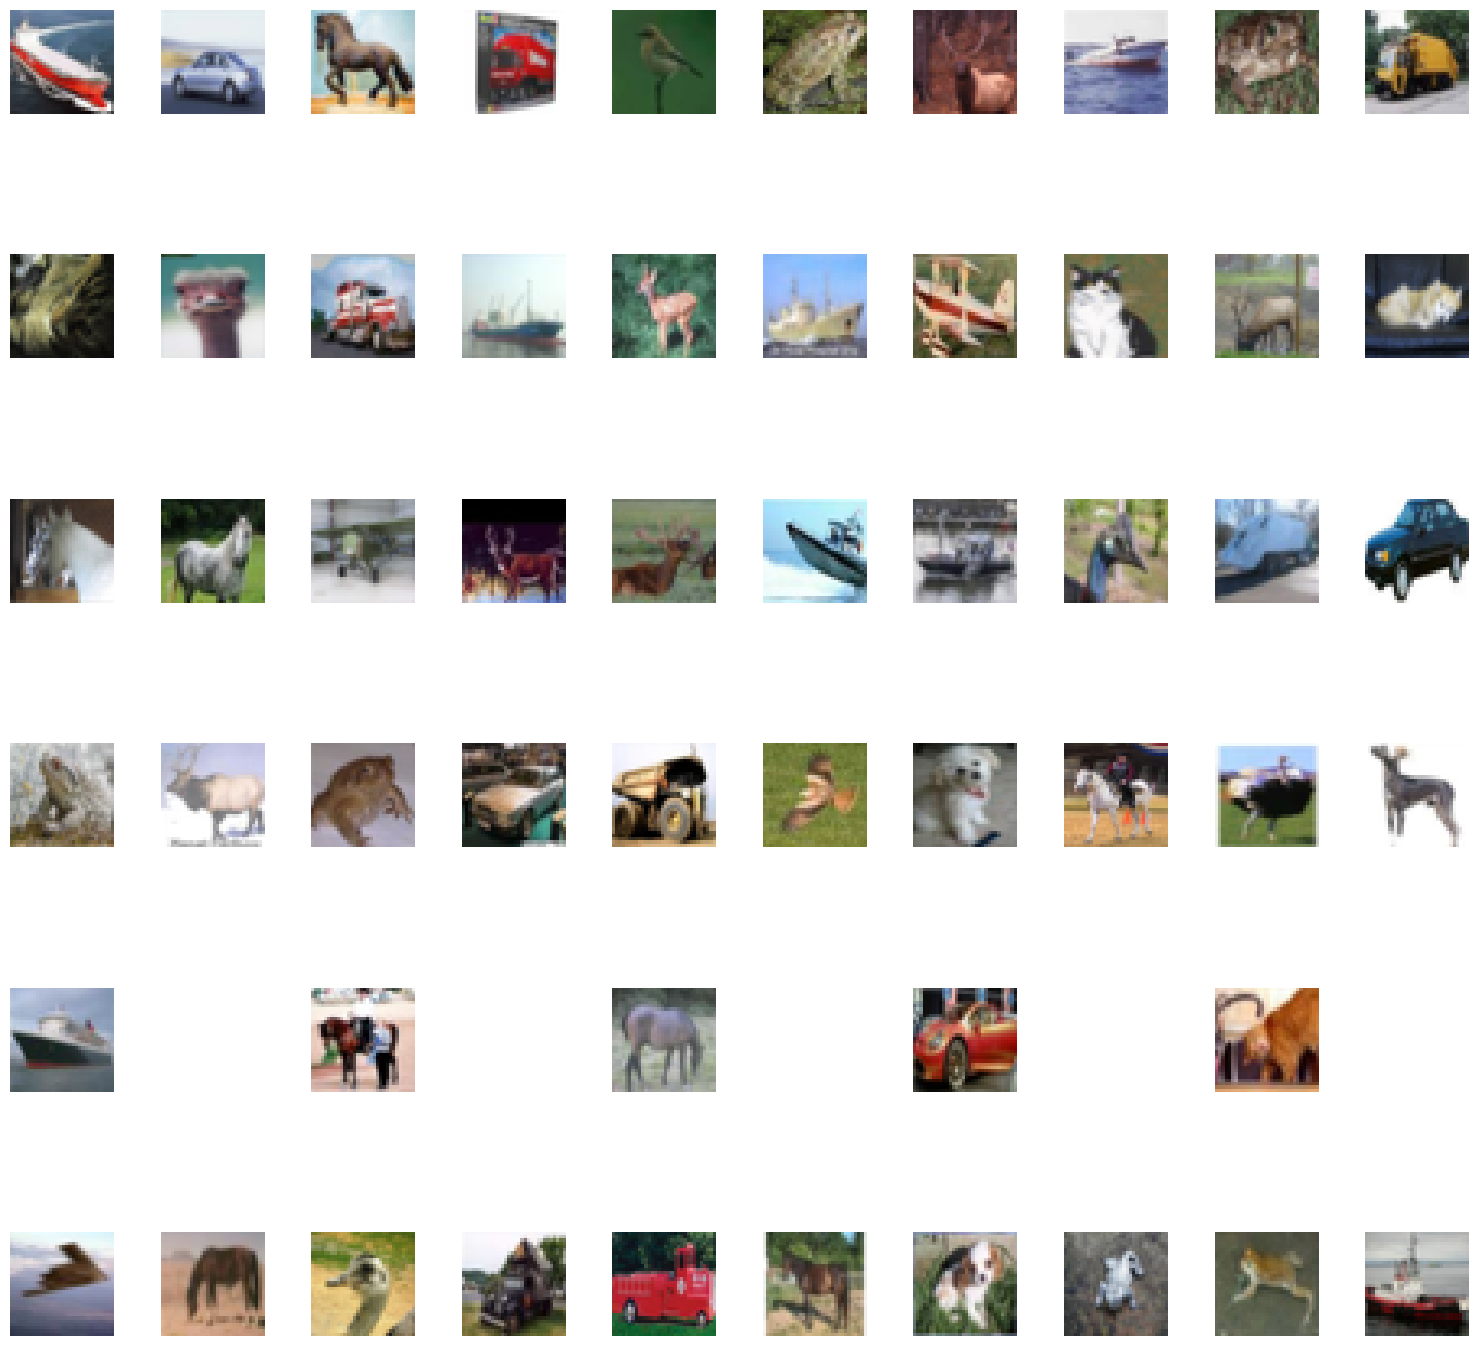

In [8]:
# View the images
figure = plt.figure(figsize=(15, 15))
num_of_images = 60
images = np.random.permutation(train_dataset.data)[:60]
for index in range(1, num_of_images+1):
    plt.subplot(6, 10, index)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(images[index-1])

In [9]:
# Define the data loaders
torch.manual_seed(1)

dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if use_gpu else dict(shuffle=True, batch_size=128)

train_loader = torch.utils.data.DataLoader(train_dataset,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset,**dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
from torchinfo import summary
model = Net(12, 22, 40).to(device)
print(summary(model, input_size=(1, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [10]                      --
├─ConvLayer: 1-1                         --                        --
│    └─Conv2d: 2-1                       [1, 12, 32, 32]           324
│    └─BatchNorm2d: 2-2                  [1, 12, 32, 32]           24
│    └─Dropout: 2-3                      [1, 12, 32, 32]           --
├─ConvLayer: 1-2                         --                        --
│    └─Conv2d: 2-4                       [1, 12, 32, 32]           1,296
│    └─BatchNorm2d: 2-5                  [1, 12, 32, 32]           24
│    └─Dropout: 2-6                      [1, 12, 32, 32]           --
├─ConvLayer: 1-3                         --                        --
│    └─Conv2d: 2-7                       [1, 12, 32, 32]           144
│    └─BatchNorm2d: 2-8                  [1, 12, 32, 32]           24
│    └─Dropout: 2-9                      [1, 12, 32, 32]           --
├─MaxPool2

/content/drive/MyDrive/ERA_S8/src/model.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [11]:
# Define the train loop
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.cpu().detach().numpy())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append((100*correct/processed))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append((100. * correct / len(test_loader.dataset)))

## Batch Norm

In [12]:
EPOCHS = 20
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model = Net(12, 22, 40).to(device)
# L2 weight decay based on DavidNet (a DAWN 2019 winning entry) - architecture very similar to ours
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.000125)

# Creating a simple LR scheduler to try
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 0


Loss=1.3556127548217773 Batch_id=97 Accuracy=36.99: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 1.8105, Accuracy: 3805/10000 (38.05%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 1


Loss=1.1685982942581177 Batch_id=97 Accuracy=52.62: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]



Test set: Average loss: 1.8159, Accuracy: 3816/10000 (38.16%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 2


Loss=1.0654237270355225 Batch_id=97 Accuracy=58.62: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]



Test set: Average loss: 1.0691, Accuracy: 6148/10000 (61.48%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 3


Loss=1.0052697658538818 Batch_id=97 Accuracy=62.51: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 1.4208, Accuracy: 5101/10000 (51.01%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 4


Loss=0.8713890314102173 Batch_id=97 Accuracy=64.38: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]



Test set: Average loss: 1.2700, Accuracy: 5643/10000 (56.43%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 5


Loss=0.9870062470436096 Batch_id=97 Accuracy=66.48: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Test set: Average loss: 1.1951, Accuracy: 5757/10000 (57.57%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 6


Loss=0.957183301448822 Batch_id=97 Accuracy=68.10: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]



Test set: Average loss: 1.0392, Accuracy: 6337/10000 (63.37%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 7


Loss=0.9481062293052673 Batch_id=97 Accuracy=69.45: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.9371, Accuracy: 6669/10000 (66.69%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 8


Loss=0.7743748426437378 Batch_id=97 Accuracy=70.91: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.9001, Accuracy: 6823/10000 (68.23%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 9


Loss=0.7438079714775085 Batch_id=97 Accuracy=71.62: 100%|██████████| 98/98 [00:31<00:00,  3.06it/s]



Test set: Average loss: 0.8737, Accuracy: 6875/10000 (68.75%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 10


Loss=0.7350489497184753 Batch_id=97 Accuracy=74.39: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]



Test set: Average loss: 0.7140, Accuracy: 7477/10000 (74.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 11


Loss=0.7854803800582886 Batch_id=97 Accuracy=75.07: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]



Test set: Average loss: 0.7084, Accuracy: 7524/10000 (75.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 12


Loss=0.7304015755653381 Batch_id=97 Accuracy=75.19: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 0.6781, Accuracy: 7637/10000 (76.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 13


Loss=0.6462830901145935 Batch_id=97 Accuracy=75.51: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]



Test set: Average loss: 0.7077, Accuracy: 7528/10000 (75.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 14


Loss=0.7064120173454285 Batch_id=97 Accuracy=75.51: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Test set: Average loss: 0.6774, Accuracy: 7614/10000 (76.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 15


Loss=0.6200779676437378 Batch_id=97 Accuracy=75.73: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 0.6915, Accuracy: 7540/10000 (75.40%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 16


Loss=0.6704880595207214 Batch_id=97 Accuracy=75.83: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.6881, Accuracy: 7583/10000 (75.83%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 17


Loss=0.6847653388977051 Batch_id=97 Accuracy=76.10: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 0.6770, Accuracy: 7610/10000 (76.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 18


Loss=0.7049567103385925 Batch_id=97 Accuracy=76.22: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 0.6916, Accuracy: 7567/10000 (75.67%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 19


Loss=0.65144282579422 Batch_id=97 Accuracy=76.27: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.6696, Accuracy: 7658/10000 (76.58%)

Adjusting learning rate of group 0 to 1.0000e-03.


In [13]:
# Save model weights
torch.save(model, 'models/model_bn.pt')

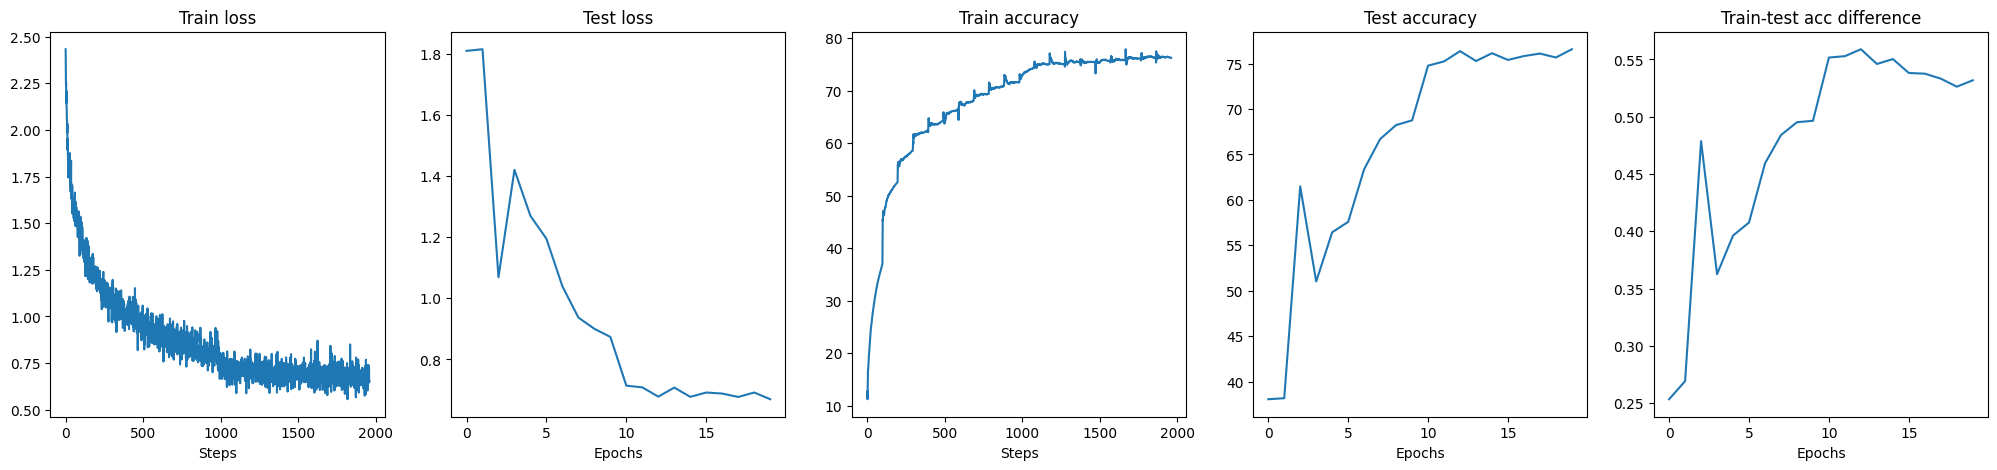

In [14]:
# Let's check for overfitting visually
train_test_diff = [np.abs(tr-te)/100 for tr, te in zip(train_acc, test_acc)]
fig, axs = plt.subplots(ncols=5,figsize=(25,5));
axs[0].plot(train_losses);
axs[0].set(title="Train loss", xlabel="Steps");

axs[1].plot(test_losses);
axs[1].set(title="Test loss", xlabel="Epochs");

axs[2].plot(train_acc);
axs[2].set(title="Train accuracy", xlabel="Steps");

axs[3].plot(test_acc);
axs[3].set(title="Test accuracy", xlabel="Epochs");

axs[4].plot(train_test_diff);
axs[4].set(title="Train-test acc difference", xlabel="Epochs");

## Layer Norm

In [15]:
EPOCHS = 20
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model = Net(12, 22, 40, norm="ln").to(device)
# L2 weight decay based on DavidNet (a DAWN 2019 winning entry) - architecture very similar to ours
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.000125)

# Creating a simple LR scheduler to try
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 0


Loss=1.4027105569839478 Batch_id=97 Accuracy=38.61: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 1.6947, Accuracy: 3830/10000 (38.30%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 1


Loss=1.1997509002685547 Batch_id=97 Accuracy=54.50: 100%|██████████| 98/98 [00:30<00:00,  3.16it/s]



Test set: Average loss: 1.4782, Accuracy: 4582/10000 (45.82%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 2


Loss=1.115440845489502 Batch_id=97 Accuracy=59.35: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 1.3963, Accuracy: 4800/10000 (48.00%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 3


Loss=0.9880222082138062 Batch_id=97 Accuracy=62.95: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 1.1985, Accuracy: 5645/10000 (56.45%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 4


Loss=0.9731769561767578 Batch_id=97 Accuracy=65.32: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 1.2136, Accuracy: 5862/10000 (58.62%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 5


Loss=0.9648591876029968 Batch_id=97 Accuracy=66.76: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]



Test set: Average loss: 1.1490, Accuracy: 6010/10000 (60.10%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 6


Loss=0.8693529963493347 Batch_id=97 Accuracy=68.15: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 1.0140, Accuracy: 6405/10000 (64.05%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 7


Loss=0.7739424705505371 Batch_id=97 Accuracy=69.68: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]



Test set: Average loss: 0.8777, Accuracy: 6837/10000 (68.37%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 8


Loss=0.7550694346427917 Batch_id=97 Accuracy=70.71: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.9304, Accuracy: 6745/10000 (67.45%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 9


Loss=0.8549968004226685 Batch_id=97 Accuracy=71.68: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]



Test set: Average loss: 0.9076, Accuracy: 6799/10000 (67.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 10


Loss=0.8065270781517029 Batch_id=97 Accuracy=74.53: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 0.7354, Accuracy: 7439/10000 (74.39%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 11


Loss=0.7863970398902893 Batch_id=97 Accuracy=74.92: 100%|██████████| 98/98 [00:30<00:00,  3.16it/s]



Test set: Average loss: 0.6911, Accuracy: 7586/10000 (75.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 12


Loss=0.743927538394928 Batch_id=97 Accuracy=75.23: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.7054, Accuracy: 7559/10000 (75.59%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 13


Loss=0.7343529462814331 Batch_id=97 Accuracy=75.48: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.7046, Accuracy: 7537/10000 (75.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 14


Loss=0.6763951182365417 Batch_id=97 Accuracy=75.78: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 0.6794, Accuracy: 7611/10000 (76.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 15


Loss=0.7907690405845642 Batch_id=97 Accuracy=75.74: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Test set: Average loss: 0.6826, Accuracy: 7612/10000 (76.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 16


Loss=0.6804548501968384 Batch_id=97 Accuracy=76.00: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]



Test set: Average loss: 0.6905, Accuracy: 7590/10000 (75.90%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 17


Loss=0.5920782089233398 Batch_id=97 Accuracy=76.18: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 0.6851, Accuracy: 7615/10000 (76.15%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 18


Loss=0.6554195880889893 Batch_id=97 Accuracy=76.19: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.6865, Accuracy: 7598/10000 (75.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 19


Loss=0.6109703183174133 Batch_id=97 Accuracy=76.28: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 0.6592, Accuracy: 7717/10000 (77.17%)

Adjusting learning rate of group 0 to 1.0000e-03.


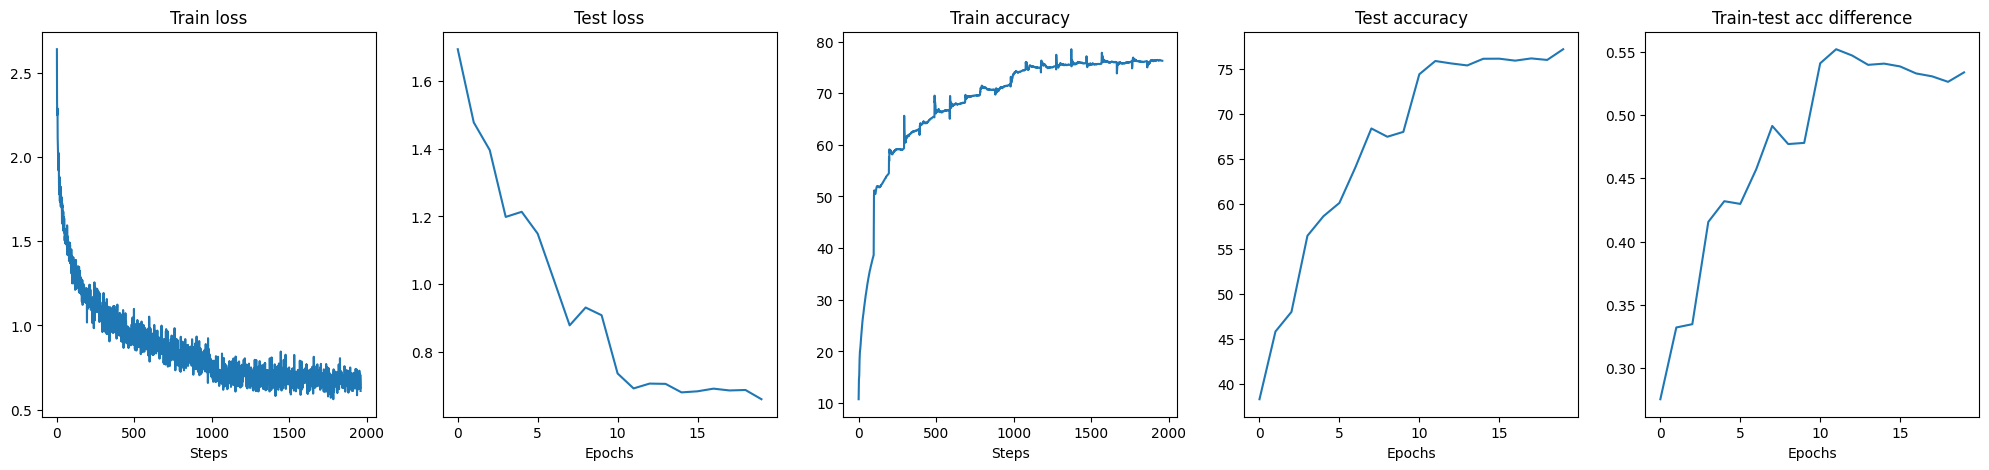

In [16]:
# Let's check for overfitting visually
train_test_diff = [np.abs(tr-te)/100 for tr, te in zip(train_acc, test_acc)]
fig, axs = plt.subplots(ncols=5,figsize=(25,5));
axs[0].plot(train_losses);
axs[0].set(title="Train loss", xlabel="Steps");

axs[1].plot(test_losses);
axs[1].set(title="Test loss", xlabel="Epochs");

axs[2].plot(train_acc);
axs[2].set(title="Train accuracy", xlabel="Steps");

axs[3].plot(test_acc);
axs[3].set(title="Test accuracy", xlabel="Epochs");

axs[4].plot(train_test_diff);
axs[4].set(title="Train-test acc difference", xlabel="Epochs");

In [17]:
# Save model weights
torch.save(model, 'models/model_ln.pt')

## Group Norm

In [18]:
EPOCHS = 20
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model = Net(12, 22, 40, norm="gn").to(device)
# L2 weight decay based on DavidNet (a DAWN 2019 winning entry) - architecture very similar to ours
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.000125)

# Creating a simple LR scheduler to try
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 0


Loss=1.5349370241165161 Batch_id=97 Accuracy=36.77: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 2.2256, Accuracy: 2767/10000 (27.67%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 1


Loss=1.247443437576294 Batch_id=97 Accuracy=53.70: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 1.3898, Accuracy: 4973/10000 (49.73%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 2


Loss=1.0979050397872925 Batch_id=97 Accuracy=58.87: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]



Test set: Average loss: 1.0952, Accuracy: 6013/10000 (60.13%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 3


Loss=1.0478850603103638 Batch_id=97 Accuracy=62.00: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 1.3162, Accuracy: 5361/10000 (53.61%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 4


Loss=1.0500195026397705 Batch_id=97 Accuracy=64.25: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 1.2065, Accuracy: 5703/10000 (57.03%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 5


Loss=0.9830317497253418 Batch_id=97 Accuracy=66.18: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]



Test set: Average loss: 1.4788, Accuracy: 5291/10000 (52.91%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 6


Loss=1.0164377689361572 Batch_id=97 Accuracy=67.19: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 1.0424, Accuracy: 6127/10000 (61.27%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 7


Loss=0.8321340680122375 Batch_id=97 Accuracy=68.22: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 1.2609, Accuracy: 5821/10000 (58.21%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 8


Loss=0.8671441674232483 Batch_id=97 Accuracy=68.83: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]



Test set: Average loss: 0.9655, Accuracy: 6568/10000 (65.68%)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 9


Loss=0.8732502460479736 Batch_id=97 Accuracy=70.12: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 0.9178, Accuracy: 6662/10000 (66.62%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 10


Loss=0.7117558717727661 Batch_id=97 Accuracy=72.38: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.8368, Accuracy: 7057/10000 (70.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 11


Loss=0.7623317241668701 Batch_id=97 Accuracy=73.28: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]



Test set: Average loss: 0.8132, Accuracy: 7121/10000 (71.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 12


Loss=0.7975975871086121 Batch_id=97 Accuracy=73.55: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.8145, Accuracy: 7117/10000 (71.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 13


Loss=0.7341925501823425 Batch_id=97 Accuracy=73.51: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Test set: Average loss: 0.7915, Accuracy: 7186/10000 (71.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 14


Loss=0.7916769981384277 Batch_id=97 Accuracy=73.69: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 0.7759, Accuracy: 7202/10000 (72.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 15


Loss=0.7340035438537598 Batch_id=97 Accuracy=74.10: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 0.8463, Accuracy: 7035/10000 (70.35%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 16


Loss=0.7369341254234314 Batch_id=97 Accuracy=74.12: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Test set: Average loss: 0.8205, Accuracy: 7098/10000 (70.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 17


Loss=0.66356360912323 Batch_id=97 Accuracy=74.31: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]



Test set: Average loss: 0.7862, Accuracy: 7232/10000 (72.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 18


Loss=0.730571448802948 Batch_id=97 Accuracy=74.19: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Test set: Average loss: 0.8559, Accuracy: 7003/10000 (70.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 19


Loss=0.7800531983375549 Batch_id=97 Accuracy=74.50: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Test set: Average loss: 0.7760, Accuracy: 7242/10000 (72.42%)

Adjusting learning rate of group 0 to 1.0000e-03.


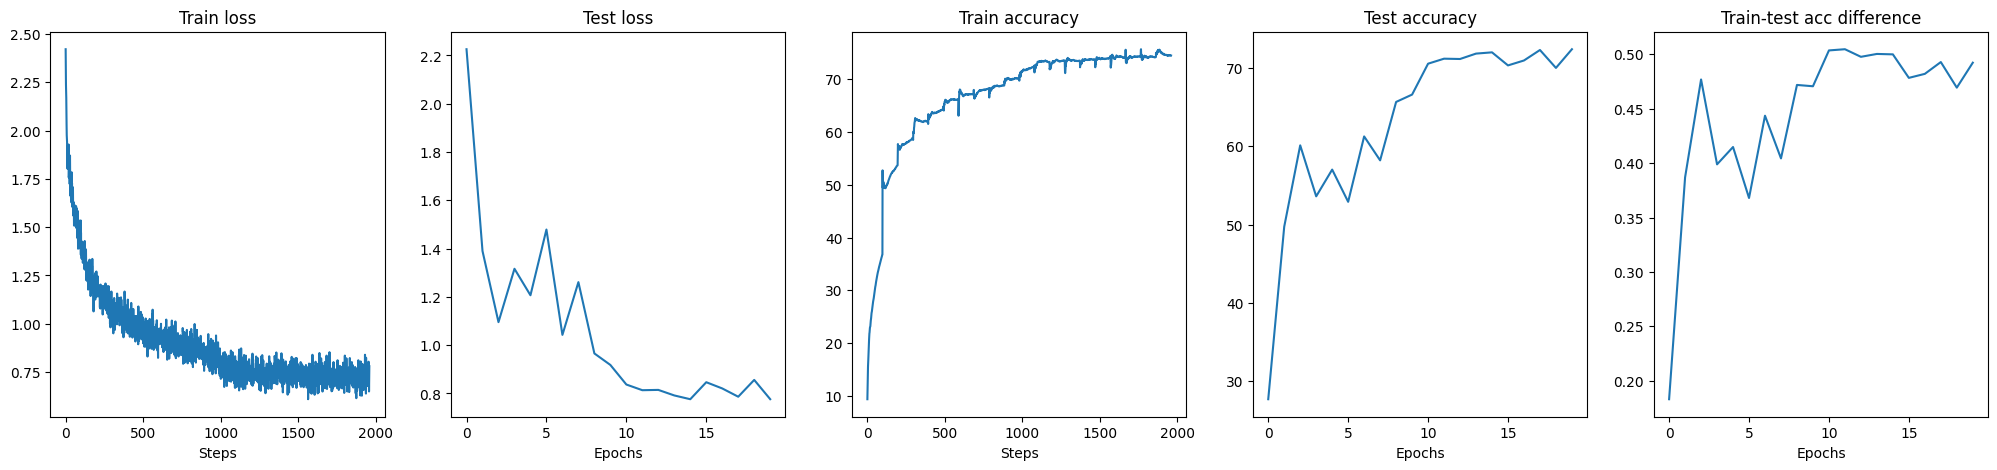

In [19]:
# Let's check for overfitting visually
train_test_diff = [np.abs(tr-te)/100 for tr, te in zip(train_acc, test_acc)]
fig, axs = plt.subplots(ncols=5,figsize=(25,5));
axs[0].plot(train_losses);
axs[0].set(title="Train loss", xlabel="Steps");

axs[1].plot(test_losses);
axs[1].set(title="Test loss", xlabel="Epochs");

axs[2].plot(train_acc);
axs[2].set(title="Train accuracy", xlabel="Steps");

axs[3].plot(test_acc);
axs[3].set(title="Test accuracy", xlabel="Epochs");

axs[4].plot(train_test_diff);
axs[4].set(title="Train-test acc difference", xlabel="Epochs");

In [20]:
torch.save(model, 'models/model_gn.pt')

## Misclassified Images